In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from tqdm.notebook import tqdm
from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
path = 'Data/Cleaned_deathCnt/*.csv'
dic_files = Load_files.load_files(path, -14, -12)
data = dic_files['서울']
data['dailyCnt'] = data['defCnt'].diff().fillna(0)
data

,deathCnt,defCnt,gubun,gubunEn,incDec,isolClearCnt,isolIngCnt,localOccCnt,overFlowCnt,qurRate,stdDay,dailyCnt
0,0,0,서울,Seoul,0.0,0,0,0,0,0.0,2020-01-20,0.0
1,0,0,서울,Seoul,0.0,0,0,0,0,0.0,2020-01-21,0.0
2,0,0,서울,Seoul,0.0,0,0,0,0,0.0,2020-01-22,0.0
3,0,0,서울,Seoul,0.0,0,0,0,0,0.0,2020-01-23,0.0
4,0,1,서울,Seoul,1.0,0,1,0,1,0.0,2020-01-24,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1214,6471,6162486,서울,Seoul,4329.0,0,0,4371,0,65361.0,2023-05-20,4329.0
1215,6473,6166682,서울,Seoul,4196.0,0,0,4195,1,65406.0,2023-05-21,4196.0
1216,6476,6167953,서울,Seoul,1271.0,0,0,1271,0,65419.0,2023-05-22,1271.0
1217,6477,6173315,서울,Seoul,5362.0,0,0,5359,3,65476.0,2023-05-23,5362.0


In [3]:
learning_rates_list = [1e-3, 1e-4, 1e-5]
patiences_list = [20, 50, 100]
num_layers_list = [2, 4, 8]
batch_sizes_list = [16, 32, 64]
hidden_sizes_list = [8, 16, 32]
dropout_list = [0.25, 0.5]

hyperparameter_dict = {}
i = 0

for lr in learning_rates_list:
    for patience in patiences_list:
        for num_layers in num_layers_list:
            for batch_sizes in batch_sizes_list:
                for hidden_size in hidden_sizes_list:    
                    for dropout in dropout_list:
                        hyperparameter_dict[i] = [lr, patience, num_layers, batch_sizes, hidden_size, dropout]
                        i += 1
                        
print(i)

486


In [4]:
criterion = nn.MSELoss()

input_size = 3
sequence_length = 60
num_epochs = 10000

df = Prepare_df.processing(data, 'stdDay', 'dailyCnt')

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

mape_min = np.inf
best_model = {}

for hyperparameter in tqdm(hyperparameter_dict.values(), desc = '서울_RNN', position = 0):
    lr = hyperparameter[0]
    patience = hyperparameter[1]
    num_layers = hyperparameter[2]
    batch_size = hyperparameter[3]
    hidden_size = hyperparameter[4]
    dropout = hyperparameter[5]
    print('-------------------------------------------------------------------------------------')
    print('lr:', lr, ' patience:', patience, ' num_layers:', num_layers, 
          ' batch_size:', batch_size, ' hidden_size:', hidden_size, ' dropout:', dropout)
    
    x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 800, 60, 1, batch_size, 'mto')
    

    model = RNN(input_size = input_size,
                hidden_size = hidden_size,
                sequence_length = sequence_length,
                num_layers = num_layers, 
                dropout = dropout, 
                device = device).to(device)

    optimizer = Adam(model.parameters(), lr = lr)
    
    loss_list, model, epoch = Trainer.Many_to_One(train_loader, 
                                                  test_loader, 
                                                  model, 
                                                  criterion, 
                                                  optimizer, 
                                                  num_epochs, 
                                                  patience,
                                                  device)
    
    label_y, predicted = predict_mto(model, df, x_ss, y_ms)
    
    if mape_min > mape(label_y+1, predicted):
        mape_min = mape(label_y+1, predicted)
        best_model['RNN'] = [mape_min, model, loss_list, epoch, lr, patience, 
                             num_layers, batch_size, hidden_size, dropout]

서울_RNN:   0%|          | 0/486 [00:00<?, ?it/s]

-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 53 loss: 0.0024
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 104 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 58 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 54 loss: 0.0009
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 49 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 58 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 96 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 96 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 66 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 108 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 46 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 94 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 80 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 115 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 120 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 61 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 75 loss: 0.0016
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 61 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 77 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 47 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 93 loss: 0.0009
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 73 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 76 loss: 0.0021
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 81 loss: 0.0020
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 39 loss: 0.0070
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 56 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 101 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 99 loss: 0.0014
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 63 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 49 loss: 0.0010
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 95 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 121 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 92 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 73 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 108 loss: 0.0019
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 105 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 113 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 22 loss: 0.0125
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 25 loss: 0.0129
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 24 loss: 0.0126
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 44 loss: 0.0124
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 42 loss: 0.0058
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 68 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 108 loss: 0.0015
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 142 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 67 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 39 loss: 0.0122
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 150 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 69 loss: 0.0015
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 49 loss: 0.0118
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 110 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 225 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 141 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 111 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 163 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 69 loss: 0.0013
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 227 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 91 loss: 0.0021
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 81 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 87 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 184 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 196 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 92 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 170 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 201 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 151 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 234 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 433 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 157 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 170 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 360 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 255 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 256 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 361 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 304 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 336 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 92 loss: 0.0014
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 72 loss: 0.0125
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 281 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 423 loss: 0.0009
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 260 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 398 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 206 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 88 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 159 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 252 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 219 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 251 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 283 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 424 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 52 loss: 0.0124
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 52 loss: 0.0126
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 64 loss: 0.0124
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 52 loss: 0.0124
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 127 loss: 0.0122
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 56 loss: 0.0125
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 352 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 277 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 144 loss: 0.0123
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 116 loss: 0.0013
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 59 loss: 0.0122
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 288 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 106 loss: 0.0010
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 316 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 309 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 506 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 283 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 266 loss: 0.0043
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 428 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 352 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 746 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 486 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 609 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 480 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 308 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 496 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 554 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 196 loss: 0.0013
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 189 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 211 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 377 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 332 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 360 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 430 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 256 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 246 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 112 loss: 0.0125
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 557 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 513 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 533 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 174 loss: 0.0175
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 214 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 504 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 505 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 585 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1011 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 340 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 283 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 551 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1024 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 455 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 962 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 220 loss: 0.0121
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 407 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 140 loss: 0.0124
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 929 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 208 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 107 loss: 0.0124
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 242 loss: 0.0124
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 141 loss: 0.0124
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 733 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 929 loss: 0.0123
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 441 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 502 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 385 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 441 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 739 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1181 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 829 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 680 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 152 loss: 0.0118
-------------------------------------------------------------------------------------
lr: 0.001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 390 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 73 loss: 0.0009
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 74 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 83 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 105 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 80 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 121 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 235 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 72 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 140 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 122 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 86 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 57 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 84 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 91 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 218 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 103 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 124 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 157 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 99 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 70 loss: 0.0015
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 62 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 74 loss: 0.0010
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 37 loss: 0.0010
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 33 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 91 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 137 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 114 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 101 loss: 0.0009
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 67 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 54 loss: 0.0015
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 154 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 113 loss: 0.0013
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 141 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 135 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 132 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 149 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 22 loss: 0.0129
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 22 loss: 0.0127
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 54 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 22 loss: 0.0132
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 35 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 77 loss: 0.0014
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 22 loss: 0.0127
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 71 loss: 0.0124
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 67 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 178 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 42 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 64 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 212 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 39 loss: 0.0118
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 157 loss: 0.0009
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 89 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 85 loss: 0.0009
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 93 loss: 0.0010
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 264 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 251 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 224 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 146 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 69 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 241 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 302 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 480 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 268 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 355 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 233 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 614 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 447 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 415 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 228 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 370 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 297 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 475 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 575 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 722 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 345 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 505 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 188 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 335 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 483 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 178 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 356 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 313 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 390 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 323 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 678 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 308 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 499 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 216 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 262 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 457 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 589 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 169 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 156 loss: 0.0010
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 52 loss: 0.0124
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 85 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 400 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 203 loss: 0.0010
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 266 loss: 0.0014
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 506 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 315 loss: 0.0009
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 370 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 115 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 313 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 277 loss: 0.0015
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 553 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 230 loss: 0.0010
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 378 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 149 loss: 0.0009
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 387 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 831 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 462 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 616 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 236 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 397 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 952 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 719 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 454 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 400 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 541 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 663 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 675 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 733 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 641 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1393 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 416 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 600 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 455 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 843 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 579 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 582 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 457 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 947 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 477 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1843 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1186 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1661 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 382 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 860 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 818 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1444 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 684 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 716 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 696 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 796 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1380 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 102 loss: 0.0123
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 813 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 562 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 469 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 953 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1074 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 809 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 663 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1622 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1043 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 163 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1717 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 629 loss: 0.0010
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 789 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1255 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 912 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 243 loss: 0.0010
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 135 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 192 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 149 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 93 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 184 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 99 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 283 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 256 loss: 0.0010
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 263 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 227 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 264 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 169 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 280 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 316 loss: 0.0009
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 290 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 211 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 162 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 181 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 296 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 343 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 235 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 131 loss: 0.0013
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 177 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 111 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 478 loss: 0.0014
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 491 loss: 0.0032
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 136 loss: 0.0013
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 189 loss: 0.0016
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 171 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 155 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 415 loss: 0.0019
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 545 loss: 0.0026
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 251 loss: 0.0013
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 242 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 208 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 249 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 31 loss: 0.0126
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 26 loss: 0.0126
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 81 loss: 0.0123
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 245 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 134 loss: 0.0010
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 183 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 34 loss: 0.0125
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 26 loss: 0.0126
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 239 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 267 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 92 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 42 loss: 0.0122
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 29 loss: 0.0120
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 54 loss: 0.0122
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 274 loss: 0.0016
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 62 loss: 0.0123
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 205 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 60 loss: 0.0119
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 415 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 552 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 501 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 399 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 626 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 422 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 828 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 390 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 668 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 818 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 547 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 730 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 375 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 612 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 452 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 355 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 679 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 689 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 467 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 488 loss: 0.0020
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 471 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 512 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 485 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 451 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 338 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 511 loss: 0.0013
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 297 loss: 0.0010
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 518 loss: 0.0009
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 647 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 215 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 399 loss: 0.0013
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 688 loss: 0.0024
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 492 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 391 loss: 0.0013
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 467 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 425 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 563 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 162 loss: 0.0125
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 248 loss: 0.0010
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 489 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 568 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 192 loss: 0.0014
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 656 loss: 0.0013
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 810 loss: 0.0020
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 424 loss: 0.0010
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 104 loss: 0.0125
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 300 loss: 0.0009
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 319 loss: 0.0010
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 830 loss: 0.0015
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 123 loss: 0.0118
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 598 loss: 0.0010
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 61 loss: 0.0123
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 373 loss: 0.0009
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 330 loss: 0.0014
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 971 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 755 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1056 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 828 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 609 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 718 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1344 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1279 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1149 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 887 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 629 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1217 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 807 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 514 loss: 0.0009
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1162 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1486 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 774 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1323 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 834 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 366 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1117 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 938 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 713 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 656 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1304 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 631 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1255 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1074 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 877 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1319 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 823 loss: 0.0009
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 603 loss: 0.0014
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1698 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 852 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1678 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1080 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 789 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 351 loss: 0.0123
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1175 loss: 0.0004
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 620 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1321 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 16  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 318 loss: 0.0010
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 326 loss: 0.0122
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 318 loss: 0.0122
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 548 loss: 0.0010
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 363 loss: 0.0016
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 994 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 647 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 993 loss: 0.0013
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 206 loss: 0.0119
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 624 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 246 loss: 0.0118
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 652 loss: 0.0009
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 100  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 364 loss: 0.0012


In [6]:
best_model

{'RNN': [399.52728748321533,
  RNN(
    (rnn): RNN(3, 8, num_layers=2, batch_first=True, dropout=0.25)
    (fc1): Linear(in_features=480, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=1, bias=True)
    (relu): ReLU()
  ),
  427,
  0.001,
  100,
  2,
  16,
  8,
  0.25]}

In [8]:
save_model(best_model['RNN'][1].state_dict(), "model/Infected/RNN.pth")
save_hyperparameter(best_model['RNN'][3:], "hyperparameter/Infected/RNN.pkl")

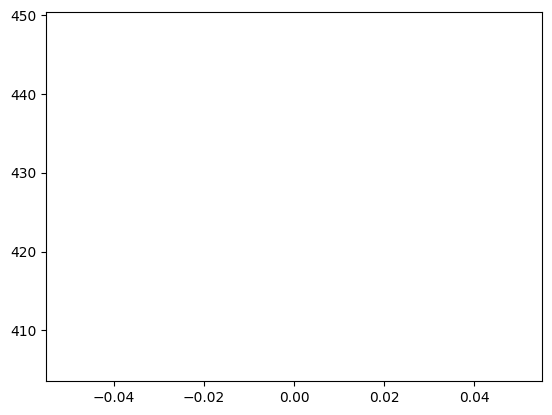

In [7]:
plt.plot(best_model['RNN'][2])

In [9]:
label_y, predicted = predict_mto(best_model['RNN'][1], df, x_ss, y_ms)

749.9142646789551


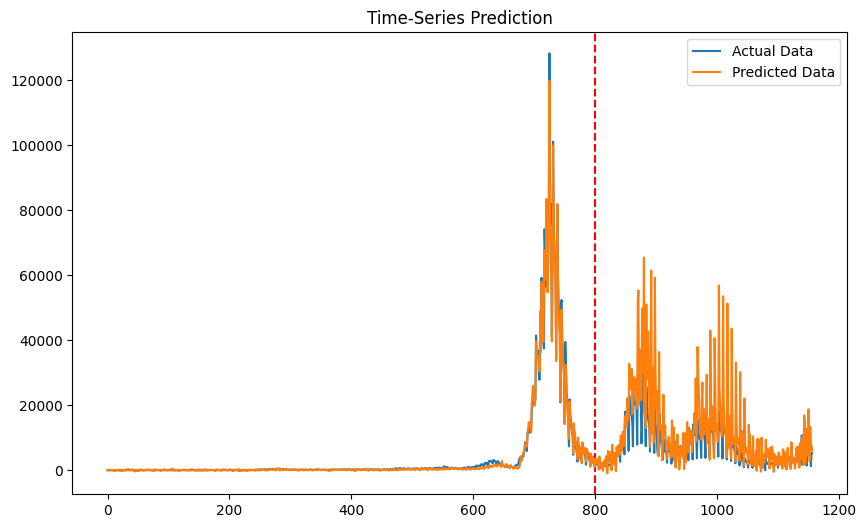

In [10]:
print(mape(label_y+1, predicted))
plotting(label_y, predicted, 800)